#  <font color='#9fb40a'> Run share of search </font>

## Set up

In [28]:
# API Key for authenticating requests to the SerpAPI service
#API_KEY = "bf3976c03caab6ea9b6c9627549552adf16e334d124a267405cc120cba926043"
API_KEY = "d0dae69c2e3712b526e1cbfef219c62a66495411620d1f66535d788a89b894ec"

# List of search queries to get data for
# Up to five terms can be specified for comparison:
#QUERIES = ['Pizza', 'Pasta', 'Spaghetti', 'Lasagna', 'Linguine']
#QUERIES = ["Enchiladas", "Burritos", "Fajitas", "Nachos", "Tacos"]
QUERIES = ["Virgin Money", "Lloyds Bank", "Barclays", "Santander Bank", "NatWest"]

# Geographic location for the search queries
# Two letter country abbreviation. Example: 'US' for United States. Defaults to 'GB' for Great Britain.
# More detailed locations can be specified, e.g., 'US-AL' for Alabama, 'GB-ENG' for England. Defaults to "World"
GEO = "GB"

# Date range for the search queries
# Default is the last 5 years ('today 5-y'). Other formats include:
# - 'all': All available data
# - 'YYYY-MM-DD YYYY-MM-DD': Specific dates, e.g., '2016-12-14 2017-01-25'
# - 'today #-m': Current time minus a number of months, e.g., 'today 3-m'
# - 'now #-d': Current time minus a number of days, e.g., 'now 7-d'
# - 'now #-H': Current time minus a number of hours, e.g., 'now 1-H'
DATE = "today 5-y"

# Granularity of the data
# Can be 'weekly' ("W"), or 'monthly'. Default is 'M' (monthly). 'daily' ("D") is experimental and not advised
GRANULARITY = "M"

# Smoothing period for the interest data
# The smoothing window in months, allowing the data to reflect a shorter-term trend.
SMOOTHING_PERIOD = 60

# Color palette for plotting
# Options include: 'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c'
PALETTE = 'tab10'

# Retry settings for API requests
# Number of retry attempts if a request fails and the delay between attempts (in seconds).
RETRY_COUNT = 3
RETRY_DELAY = 5

# Advanced Keywords:
# When using Google Trends dashboard, Google may provide suggested narrowed search terms.
# For example, "iron" will have a dropdown of "Iron Chemical Element, Iron Cross, Iron Man, etc."
# Use the get_suggestions() function to find the encoded topic and choose the most relevant one for your analysis.
# For example: "/m/025rw19" is the topic for "Iron Chemical Element".
# You can use this topic directly with pytrends to perform more focused data analysis.

In [40]:
# Install libraries
import os, re, requests, csv
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib.pyplot as matplotlib
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
from requests.exceptions import ChunkedEncodingError

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings( "ignore", module = "matplotlib\..*" )

## Define Functions

In [30]:
def fetch_data(query, geo, date, api_key):
    """
    Fetches Google Trends data for a given query and geographic location.

    Args:
        query (str): The search query term.
        geo (str): The geographic location for the search query.
        date (str): The date range for the search query.
        api_key (str): The API key for authenticating the request.

    Returns:
        list: A list of dictionaries containing the timeline data.

    Raises:
        ChunkedEncodingError: If a chunked encoding error occurs after retrying.
    """
    url = "https://serpapi.com/search"
    params = {
        "engine": "google_trends",
        "q": query,
        "geo": geo,
        "date_type": "TIMESERIES",
        "date": date,
        "api_key": api_key
    }

    for attempt in range(RETRY_COUNT):
        try:
            response = requests.get(url, params=params)
            response.raise_for_status()
            return response.json()['interest_over_time']['timeline_data']
        except ChunkedEncodingError:
            if attempt < RETRY_COUNT - 1:
                time.sleep(RETRY_DELAY)
            else:
                raise

In [31]:
def parse_date_range(date_str):
    """
    Parses a date range string and returns the start and end dates.

    Args:
        date_str (str): A string representing the date range in the format "<years>-y",
                        where <years> is the number of years back from the current date.

    Returns:
        tuple: A tuple containing the start date (datetime) and end date (datetime).

    Raises:
        ValueError: If the date string format is not recognized.
    """
    # Extract the number of years from the date string using regex.
    match = re.search(r"(\d+)-y", date_str)
    if match:
        years_back = int(match.group(1))
    else:
        raise ValueError("Date string format not recognized.")

    # Get the current date and time, rounded to the nearest second.
    now = datetime.now().replace(microsecond=0)
    end_date = now

    # Calculate the number of leap years in the specified period.
    leap_years = sum(1 for year in range(end_date.year - years_back, end_date.year)
                     if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0))

    # Calculate the start date by subtracting the total number of days (including leap days).
    start_date = end_date - timedelta(days=years_back * 365 + leap_years)

    return start_date, end_date


In [32]:
def plot_share_of_search(df):
    """
    Plots the share of search over time for different queries as a stacked area chart.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot. Must include columns 'Date',
                           'Query', and 'Share_of_Search'.
    """
    fig, ax = plt.subplots(figsize=(16, 10))

    # Create a pivot table for plotting
    pivot_table = df.pivot_table(index='Date', columns='Query', values='Share_of_Search', fill_value=0)
    pivot_table.plot(kind='area', stacked=True, colormap=PALETTE, ax=ax)

    # Set the limits for the x-axis
    ax.set_xlim([df['Date'].min(), df['Date'].max()])
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))

    # Add synthetic x-axis for annual labels
    ax2 = ax.twiny()
    ax2.set_xlim([df['Date'].min(), df['Date'].max()])
    ax2.set_xticks(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='YS'))
    ax2.set_xticklabels(pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='YS').year)
    ax2.set_xlabel('Year')

    # Format the x-axis dates and set labels
    plt.gcf().autofmt_xdate()
    plt.xlabel('Date')
    plt.ylabel('Share of Search (%)')
    plt.title('Share of Search Over Time')

    # Add a legend
    plt.legend()

    # Enable grid lines
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig("share_of_search_over_time.png")

    # Show the plot
    plt.show()

In [33]:
def plot_smoothed_interest_over_time(df):
    """
    Plots the smoothed interest over time for different queries.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot. Must include columns 'Date',
                           'Query', and 'Interest'.
    """
    fig, ax = plt.subplots(figsize=(16, 10))

    # Plot the interest over time for each query
    for query in df['Query'].unique():
        query_df = df[df['Query'] == query]
        ax.plot(query_df['Date'], query_df['Interest'], label=query)

    # Set the x-axis to show major ticks every 6 months
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

    # Format the x-axis dates and set labels
    plt.gcf().autofmt_xdate(rotation=45)

    # Add a legend
    plt.legend()

    # Set the plot title
    title = f"Smoothed Interest Over Time: Geo={GEO}, Date Range={DATE}, Granularity={GRANULARITY}, Smoothing={SMOOTHING_PERIOD}"
    plt.title(title)

    # Set the axis labels
    plt.xlabel('Date')
    plt.ylabel('Interest')

    # Enable grid lines
    plt.grid(True)

    # Save the plot as a PNG file
    plt.savefig("Smoothed_interest_over_time.png")

    # Show the plot
    plt.show()

In [34]:
def plot_smoothed_interest_over_time_split(df):
    """
    Creates a panel of charts showing smoothed interest over time for different queries.
    Each panel highlights the individual query while graying out others.

    Args:
        df (pd.DataFrame): DataFrame containing the data to plot. Must include columns 'Date',
                           'Query', and 'Interest'.
    """
    # Initialize the FacetGrid object
    g = sns.FacetGrid(df, col="Query", col_wrap=3, height=4, sharey=True)

    def plot_with_others_gray(data, color, **kwargs):
        """
        Helper function to plot the current query with other queries grayed out.
        """
        for query in df['Query'].unique():
            if query != data['Query'].iloc[0]:
                sns.lineplot(data=df[df['Query'] == query], x="Date", y="Interest", color="gray", alpha=0.3, **kwargs)
        sns.lineplot(data=data, x="Date", y="Interest", color=color, **kwargs)

    # Map the plotting function to each subset of the data
    g.map_dataframe(plot_with_others_gray)

    # Set axis labels and titles
    g.set_axis_labels("Date", "Interest")
    g.set_titles(col_template="{col_name}")
    g.set_xticklabels(rotation=45)
    g.set(xlim=(df['Date'].min(), df['Date'].max()))

    # Adjust the subplot layout and add a super title
    plt.subplots_adjust(top=0.9)
    subtitle = f"Smoothed Interest Over Time: Geo={GEO}, Date Range={DATE}, Granularity={GRANULARITY}, Smoothing={SMOOTHING_PERIOD}"
    g.fig.suptitle(subtitle)

    # Set major ticks and format the x-axis dates
    for ax in g.axes.flat:
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Save the plot as a PNG file
    plt.savefig("Smoothed_interest_over_time_split.png")

    # Show the plot
    plt.show()

## Main logic

Min Date: 2019-05-26 00:00:00
Max Date: 2024-05-26 00:00:00


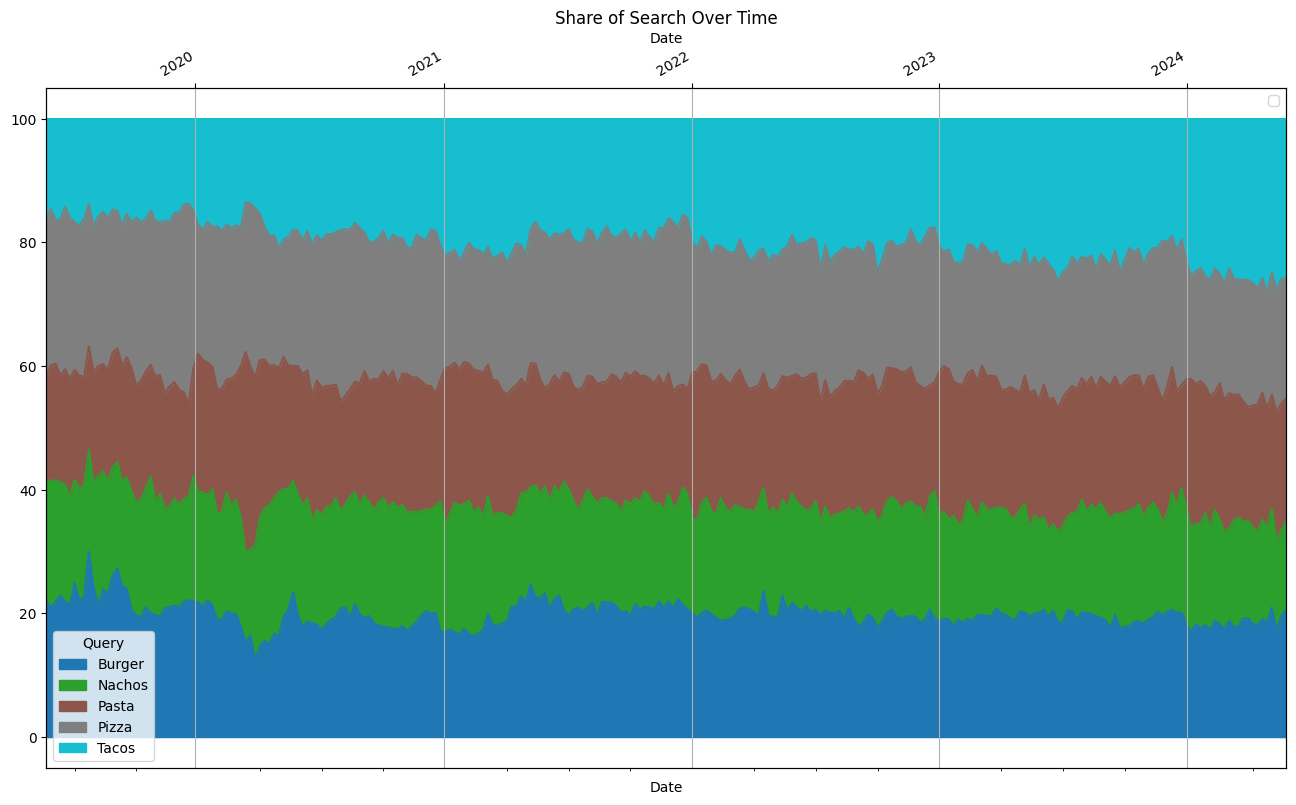

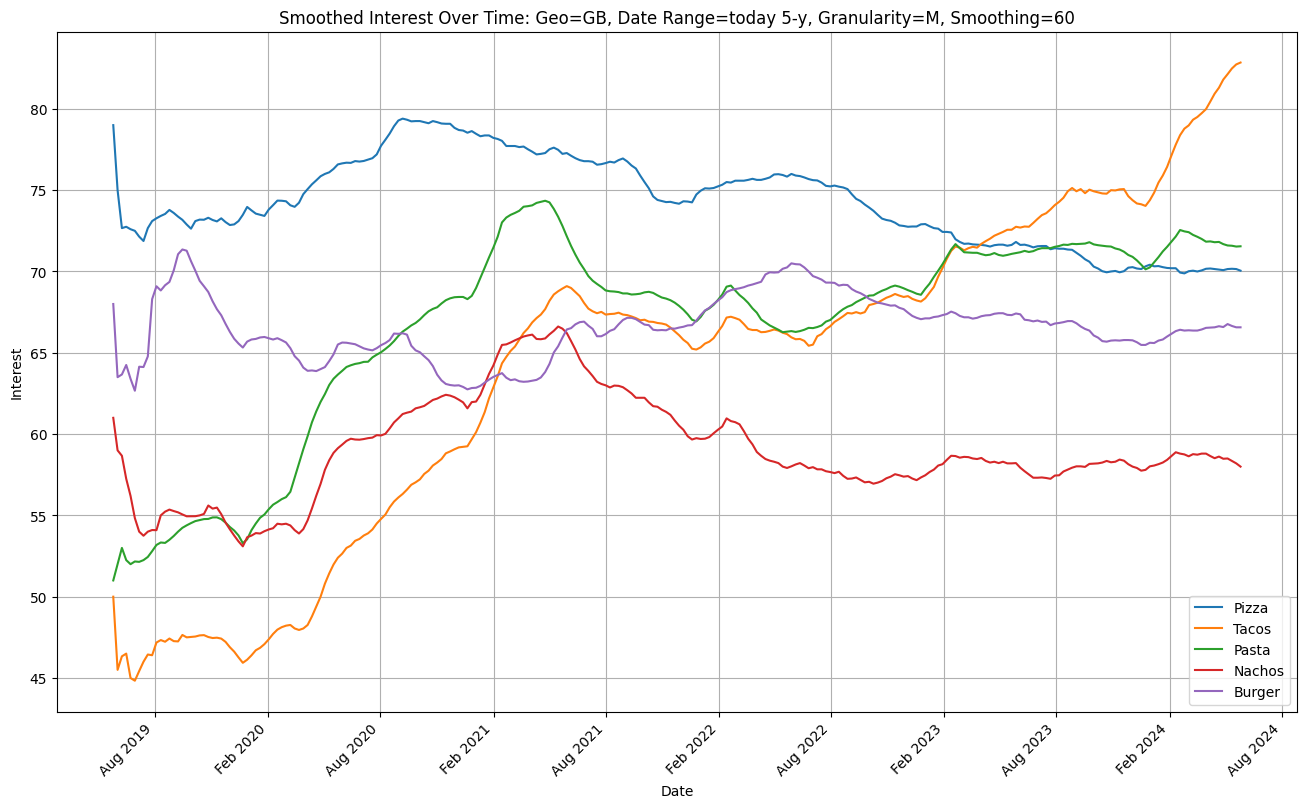

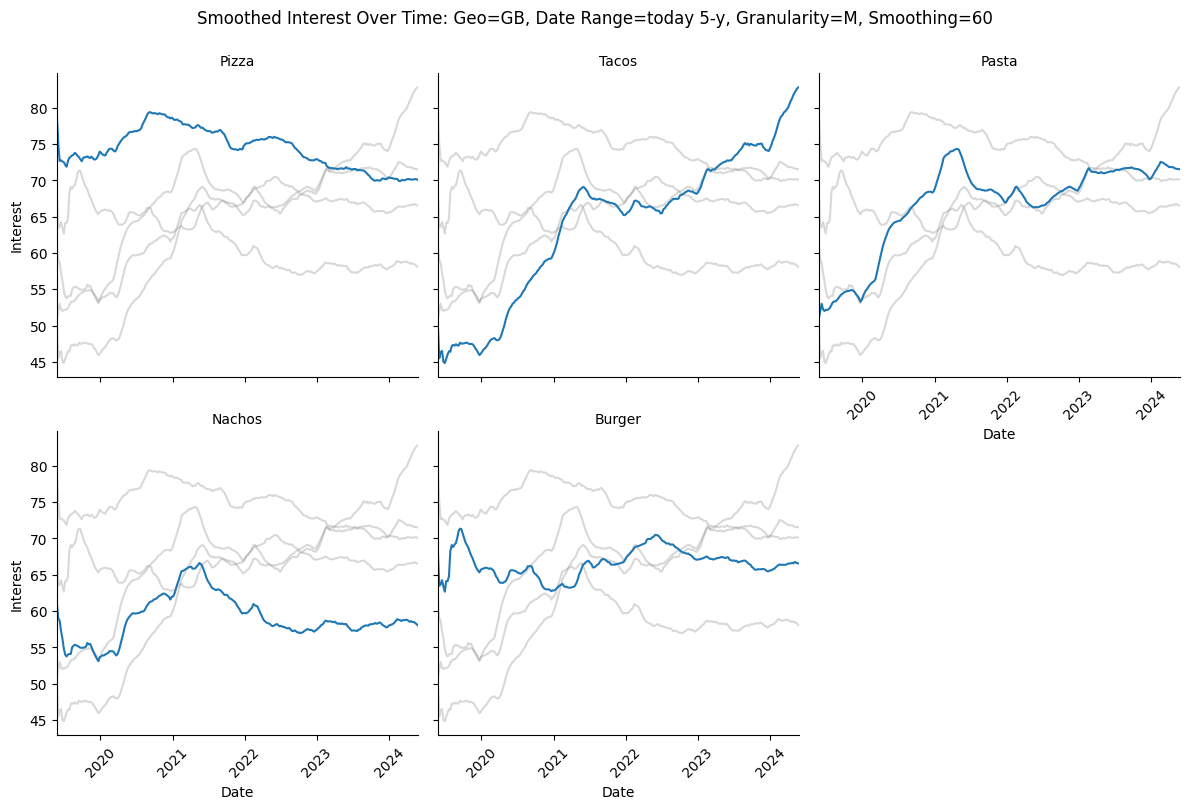

In [35]:
all_data = []

for query in QUERIES:
    timeline_data = fetch_data(query, GEO, DATE, API_KEY)
    dates = [datetime.utcfromtimestamp(int(point['timestamp'])) for point in timeline_data]
    values = [point['values'][0]['extracted_value'] for point in timeline_data]
    df = pd.DataFrame({'Date': dates, 'Interest': pd.to_numeric(values, errors='coerce'), 'Query': query})
    all_data.append(df)

# Concatenate all data into one DataFrame
combined_df = pd.concat(all_data)
combined_df.sort_values('Date', inplace=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Additional Data Transformations
combined_df['Total_Interest'] = combined_df.groupby('Date')['Interest'].transform('sum')
combined_df['Share_of_Search'] = combined_df['Interest'] / combined_df['Total_Interest'] * 100
smoothed_df = combined_df.copy()
smoothed_df['Interest'] = smoothed_df.groupby('Query')['Interest'].transform(lambda x: x.rolling(window=SMOOTHING_PERIOD, min_periods=1).mean())

# Parse date range
start_date, end_date = parse_date_range(DATE)

# Debugging: Print min and max dates
print("Min Date:", combined_df['Date'].min())
print("Max Date:", combined_df['Date'].max())

# Execute plotting
plot_share_of_search(combined_df)
plot_smoothed_interest_over_time(smoothed_df)

plot_smoothed_interest_over_time_split(smoothed_df)

# Save all DataFrames to CSV
combined_df.to_csv("Share_of_Search.csv", index=False)
smoothed_df.to_csv("Smoothed.csv", index=False)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#  <font color='#f4a127'> Run related queries </font>

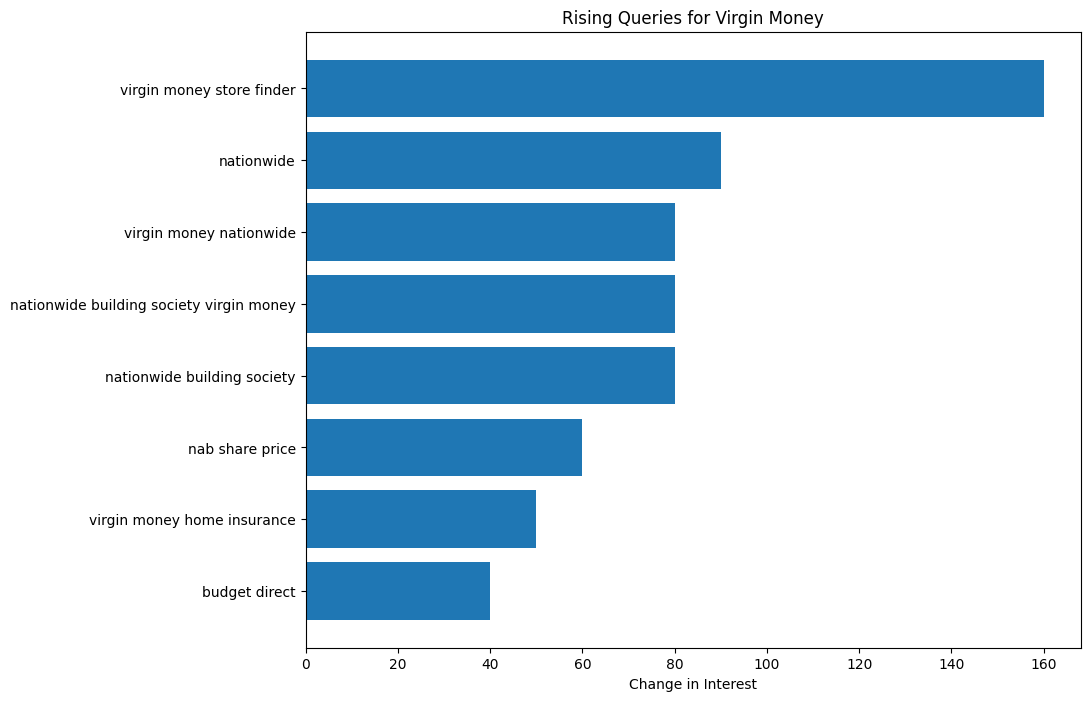

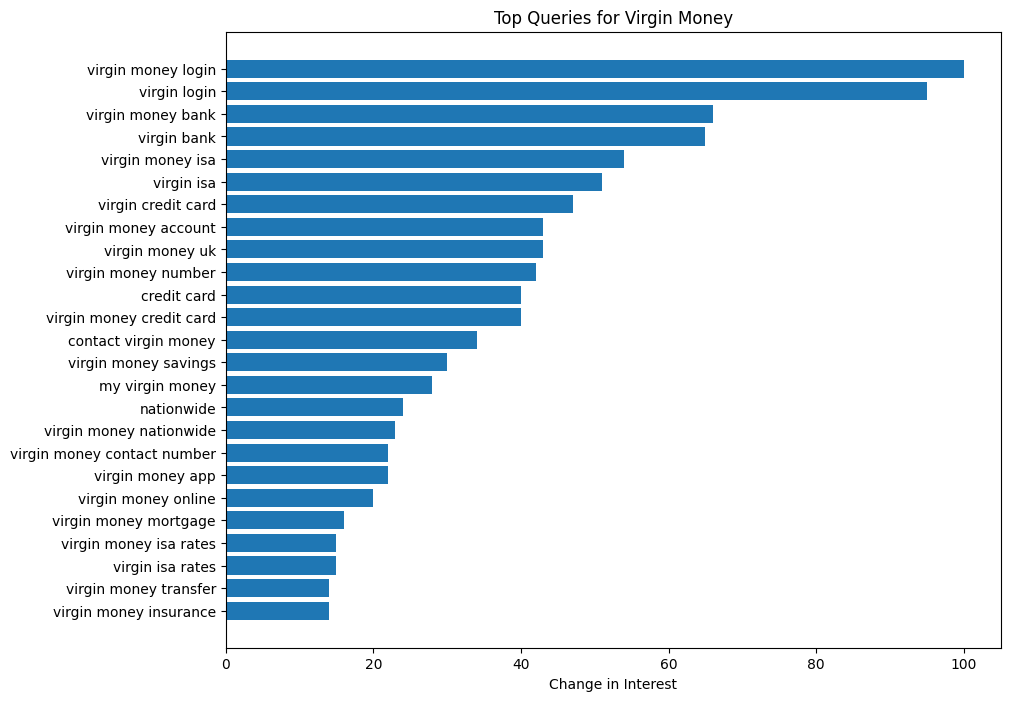

In [42]:
import requests
import csv
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_related_queries(search_term):
    # API parameters
    api_key = API_KEY
    params = {
        'engine': 'google_trends',
        'q': search_term,
        'data_type': 'RELATED_QUERIES',
        'api_key': api_key
    }
    url = 'https://serpapi.com/search.json'

    # Send GET request
    response = requests.get(url, params=params)

    # Prepare CSV files
    timestamp = datetime.now().strftime("%Y-%m-%d")
    rising_filename = f"{search_term}_rising_{timestamp}.csv"
    top_filename = f"{search_term}_top_{timestamp}.csv"

    if response.status_code == 200:
        data = response.json()
        related_queries = data.get('related_queries', {})

        # Save and plot rising queries
        save_queries(related_queries.get('rising', []), rising_filename)
        plot_queries(related_queries.get('rising', []), 'Rising Queries for ' + search_term)

        # Save and plot top queries
        save_queries(related_queries.get('top', []), top_filename)
        plot_queries(related_queries.get('top', []), 'Top Queries for ' + search_term)

    else:
        print("Failed to fetch related queries:", response.status_code, response.text)

def save_queries(queries, filename):
    keys = ['query', 'value', 'link']
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=keys)
        writer.writeheader()
        for query in queries:
            writer.writerow({key: query[key] for key in keys})

def plot_queries(queries, title):
    queries = [q for q in queries if q['value'].strip('%+').isnumeric()]
    queries.sort(key=lambda x: int(x['value'].strip('%+')), reverse=True)
    labels = [q['query'] for q in queries]
    values = [int(q['value'].strip('%+')) for q in queries]

    plt.figure(figsize=(10, 8))
    plt.barh(labels, values)
    plt.xlabel('Change in Interest')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.savefig(f"{title}.png")
    plt.show()

# Example usage
search_term = "Virgin Money"
fetch_related_queries(search_term)


#  <font color='#f3c64b'> Run related topics </font>

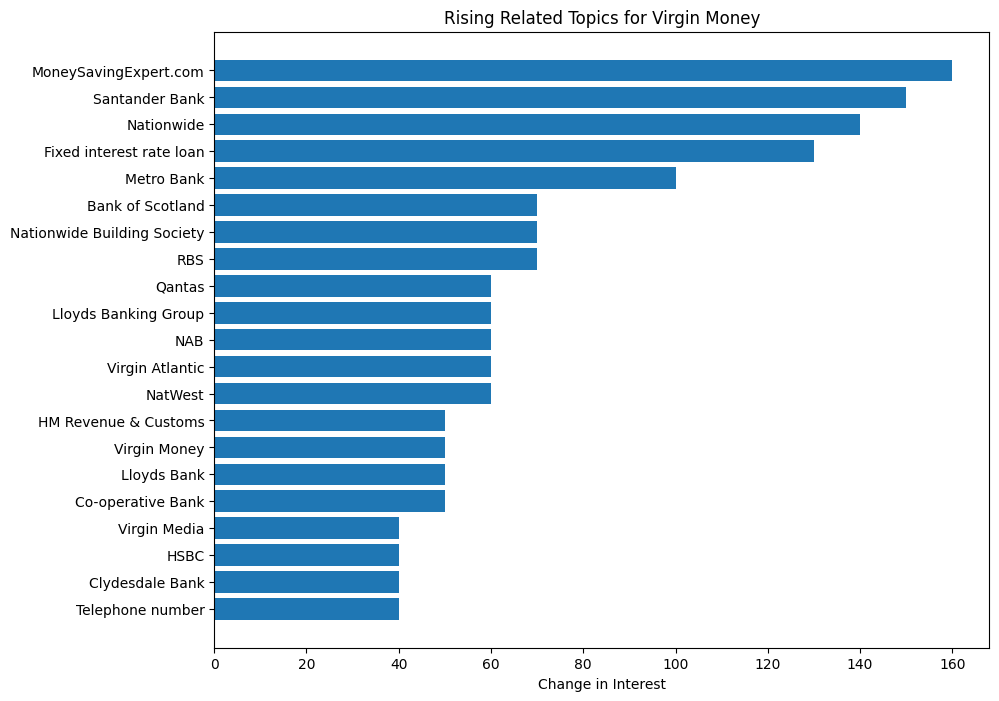

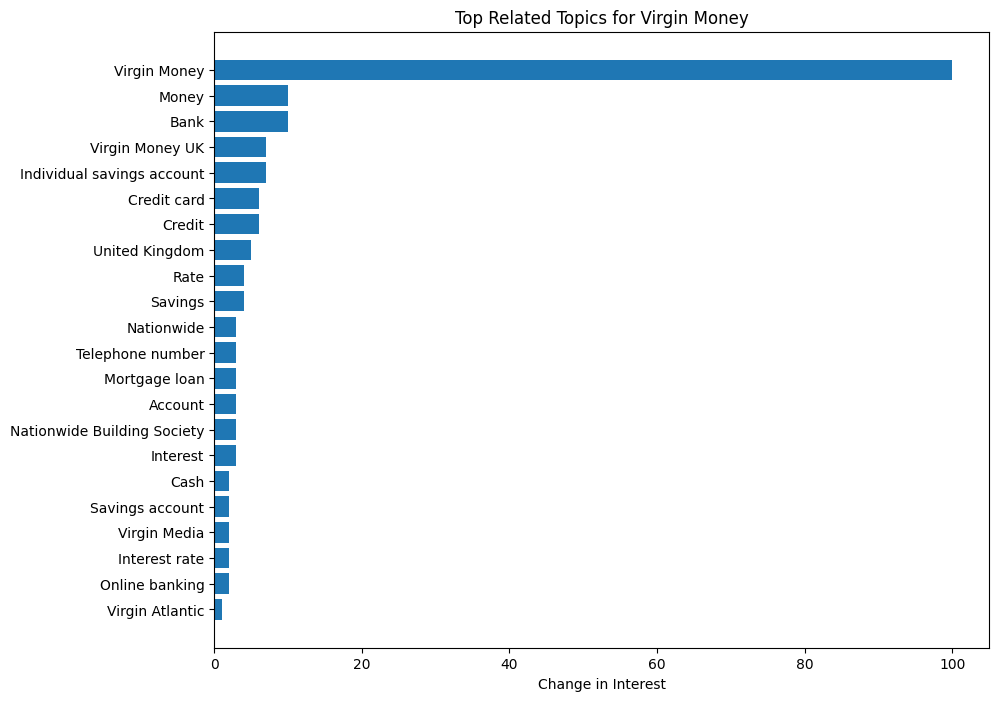

In [43]:
import requests
import csv
import matplotlib.pyplot as plt
from datetime import datetime

def fetch_related_topics(search_term):
    # API parameters
    api_key = API_KEY
    params = {
        'engine': 'google_trends',
        'q': search_term,
        'data_type': 'RELATED_TOPICS',
        'api_key': api_key
    }
    url = 'https://serpapi.com/search.json'

    # Send GET request
    response = requests.get(url, params=params)

    # Prepare CSV and PNG files
    timestamp = datetime.now().strftime("%Y-%m-%d")
    rising_filename = f"{search_term}_related_topics_rising_{timestamp}.csv"
    top_filename = f"{search_term}_related_topics_top_{timestamp}.csv"
    rising_png = f"{search_term}_related_topics_rising_{timestamp}.png"
    top_png = f"{search_term}_related_topics_top_{timestamp}.png"

    if response.status_code == 200:
        data = response.json()
        related_topics = data.get('related_topics', {})

        # Save and plot rising topics
        save_topics(related_topics.get('rising', []), rising_filename)
        plot_topics(related_topics.get('rising', []), 'Rising Related Topics for ' + search_term, rising_png)

        # Save and plot top topics
        save_topics(related_topics.get('top', []), top_filename)
        plot_topics(related_topics.get('top', []), 'Top Related Topics for ' + search_term, top_png)

    else:
        print("Failed to fetch related topics:", response.status_code, response.text)

def save_topics(topics, filename):
    keys = ['title', 'type', 'value']
    with open(filename, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(keys)
        for topic in topics:
            writer.writerow([topic['topic']['title'], topic['topic']['type'], topic['value']])

def plot_topics(topics, title, filename):
    topics = [t for t in topics if t['value'].strip('%+').isnumeric()]
    topics.sort(key=lambda x: int(x['value'].strip('%+')), reverse=True)
    labels = [t['topic']['title'] for t in topics]
    values = [int(t['value'].strip('%+')) for t in topics]

    plt.figure(figsize=(10, 8))
    plt.barh(labels, values)
    plt.xlabel('Change in Interest')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.savefig(filename)  # Save the figure to a file
    plt.show()  # Display the figure

# Example usage
search_term = 'Virgin Money'
fetch_related_topics(search_term)

#  <font color='#714930'>  Download files </font>

In [ ]:
from google.colab import files
import os
from datetime import datetime

def create_downloadable_zip(excluded_files, zip_name='SoS_output_files'):
    # Get the current date in YYYY-MM-DD format
    date_str = datetime.now().strftime("%Y-%m-%d")
    # Update zip_name to include the current date
    zip_name = f"{zip_name}_{date_str}.zip"

    # Start command
    command = "zip -r " + zip_name + " /content"

    # Exclude files
    for file in excluded_files:
        command += " -x " + "\"*/" + file + "*\""

    # Run the command
    os.system(command)
    # Download the file
    files.download(zip_name)

# List of files to exclude
excluded_files = [
    "drive",
    "sample_data",
    "raw_data.csv"
]

# Download files
create_downloadable_zip(excluded_files)